# TFM. Deep Visin applied to Real state.

https://docs.google.com/document/d/1z8G_THiNSHe14UcoJhIIcJL4NLlCuOiVTu6yvla37qo/edit#d


In [1]:
# google stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [3]:
%tensorflow_version 2.x
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# architecture 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
#from keras.layers import GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import Model

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# optimization
from tensorflow.keras.optimizers import Adam
from keras import regularizers
#from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, BatchNormalization, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.regularizers import l1_l2, l2

# pre-trained models
#from tensorflow.keras.applications import VGG16, ResNet50, VGG19

import os
import pickle
import tarfile

# counting classes with library
from collections import Counter

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

- base directory

In [4]:
!ls "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"

 AlbertoVargas-sistema_clasificacion_viviendas_imagenes.gslides   input    src
'Dudas y seguimiento TFM.gdoc'					  output


In [5]:
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/" #for pickling data
input = input_folder+"House_Room_Dataset-5_rooms" # for requesting directly pics
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

- functions

In [6]:
# insert the directory
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

In [7]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD#, Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

from my_functions import freezing_layers, vgg16_19_conf, resnet50_conf, nn_parameters, plotting_model, generic_last_2layers
from datetime import datetime

# calling pics from folder 
(instead of pickling them)
https://keras.io/examples/vision/image_classification_from_scratch/

In [8]:
image_size = (128,128)
batch_size = 32
# https://www.tensorflow.org/tutorials/images/classification
train_ds = image_dataset_from_directory(
    input,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    # labels='inferred',
    # label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='rgb'
)
val_ds = image_dataset_from_directory(
    input,
    # labels='inferred',
    # label_mode='categorical',
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    validation_split=0.2,
    subset="validation",
    seed=4123,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='rgb'
)

Found 5250 files belonging to 5 classes.
Using 4200 files for training.
Found 5250 files belonging to 5 classes.
Using 1050 files for validation.


In [9]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

## applying configuration to my models

- data augmentation

In [10]:
from keras.models import Sequential
from tensorflow.keras import layers

# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [
    layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.005),
    #random_invert(0.2),  # color inversion
    layers.RandomContrast(0.2),
    #Contrast(),
    #layers.RandomCrop(image_size[0],image_size[1]), 
    #layers.RandomZoom(height_factor=0.01 , width_factor=0.01 , fill_mode='reflect',interpolation='bilinear', fill_value=0.0),
    layers.RandomWidth(0.05, interpolation="gaussian"),
    layers.RandomHeight(0.05),
    layers.RandomTranslation((-0.2,0.3),(-0.2,0.3), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0),
  ]
)

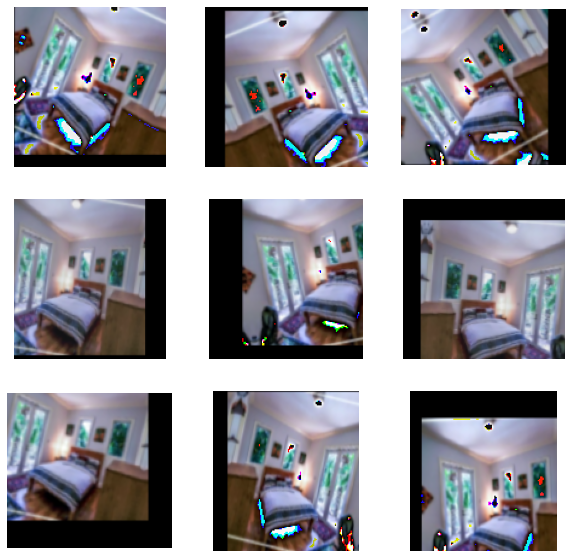

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

- functions

In [12]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import VGG16, VGG19

class Contrast(Layer):
    def __init__(self, contrast_level=2.0, **kwargs):
        self.contrast_level = contrast_level
        super().__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
      channel_mean = tf.math.reduce_mean(inputs, [1, 2], keepdims=True)
      return (inputs - channel_mean) * self.contrast_level + channel_mean

# color inversion
def random_invert_img(x, p=0.5):
  '''
  https://www.tensorflow.org/tutorials/images/data_augmentation
  '''
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))



class Contrast(Layer):
  '''
  random inversion of colors
  '''
  def __init__(self, contrast_level=2.0, **kwargs):
      self.contrast_level = contrast_level
      super().__init__(**kwargs)
      self.supports_masking = True

  def call(self, inputs, training=None):
    channel_mean = tf.math.reduce_mean(inputs, [1, 2], keepdims=True)
    return (inputs - channel_mean) * self.contrast_level + channel_mean


def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  works with pre-trained models for transfer-learning
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(Dropout(dropout_percent)) 
          pre_trained.add(GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          pre_trained.add(Dense(neurons_final_layer,activation=('softmax')))

      elif dropout_position == "middle":
          pre_trained.add(GlobalAveragePooling2D()) 
          pre_trained.add(Dropout(dropout_percent)) 
          pre_trained.add(Dense(neurons_final_layer,activation=('softmax')))
      
  else:
    pre_trained.add(GlobalAveragePooling2D())
    pre_trained.add(Dense(neurons_final_layer,activation=('softmax')))

  return pre_trained


def compiling_model(model, optimizer:str, loss:str):
    '''
    - optimizer = "adam", etc
    - loss      = "categorical_crossentropy", etc
    '''
    return model.compile( optimizer= optimizer,
                          loss=loss , 
                          metrics=['accuracy']
                         )
    
def naming_model(model):
  '''gives a name to save it after training'''
  # if model== pre_trained_vgg16_drop:
  #   name = "vgg16_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  # elif model == pre_trained_vgg19_drop:
  #   name = "vgg19_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  # # elif model == pre_trained_resnet50:
  #   name = "resnet50-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  if model == pre_trained_xception:
    name = "xception-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception_drop:
    name = "xception_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception:
    name = "InceptionResNetV2-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception_drop:
    name = "InceptionResNetV2_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  else: 
    raise ValueError("not model available for naming")
    return None
  return name
    
    
def plotting_godness(history,epochs, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(name+'=>  Train & Val Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Train & Val Loss')
    plt.show()

- **problemas con el shape de los tensores para vgg16-vgg19**

In [13]:
# from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
# from tensorflow.keras.applications import Xception, InceptionResNetV2, DenseNet121
# from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, MaxPooling2D, Flatten #, 
# from tensorflow.keras.models import Sequential

# def vgg16_19_conf(data_augmentation, name: str, neurons_final_layer:int, dropout_layers: bool, dropout_percent: float, dropout_position: str):
#   '''
#   creates a vgg16/19 architecture ready for transfer-learning (all layers frozen but top model). Choose the number of neurons in the last layer, if including
#   dropout layers after dense layers and percentaje
#   options: vgg16, vgg19
#   EX: vgg16_19_conf("vgg16",5, True, 0.2)
#   '''
#   pre_trained = Sequential()
#   #pre_trained.add(Input(shape=image_size))

#   if data_augmentation:
#     #data augmentation
#     pre_trained.add(data_augmentation)
#     pre_trained.add(layers.Reshape((4,4,512))) # intentando areglar el error

#     pre_trained.add(layers.Rescaling(1./255))

#   # choosing nn
#   if name =="vgg16":
#     base_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = neurons_final_layer, classifier_activation='softmax')
#   elif name == "vgg19":
#     base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = neurons_final_layer, classifier_activation='softmax')
#   else:
#     raise ValueError("check descripcion and choose a proper one")

#   pre_trained.add(base_model)

#   # adding base model layers to our architecture => this wasn't working out
#   # for layer in base_model.layers:
#   #   model.add(layer) 
#   #   layer.trainable=False

#   # Freeze the layers 
#   for layer in pre_trained.layers:
#       layer.trainable = False

#   pre_trained.add(layers.Flatten())

#   #adding top model with/without dropout
#   if dropout_layers is True:
#       if dropout_position=="first":
#           pre_trained.add(Dropout(dropout_percent)) 
#           pre_trained.add(Dense(4096,activation=('relu')))
#           pre_trained.add(Dense(4096,activation=('relu'))) #https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
#           pre_trained.add(Dense(neurons_final_layer,activation=('softmax')))

#       elif dropout_position == "middle":
#           pre_trained.add(Dense(4096,activation=('relu')))
#           pre_trained.add(Dropout(dropout_percent)) 
#           pre_trained.add(Dense(4096,activation=('relu')))
#           pre_trained.add(Dense(neurons_final_layer,activation=('softmax')))
      
#   else:
#     pre_trained.add(Dense(4096,activation=('relu')))
#     pre_trained.add(layers.Dense(4096,activation=('relu')))
#     pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))

#   return pre_trained


# num_classes=5

# pre_trained_vgg16_drop = vgg16_19_conf(data_augmentation, name="vgg16", neurons_final_layer=num_classes, dropout_layers= True, dropout_percent=0.2, dropout_position="first")
# #pre_trained_vgg16_drop = vgg16_19_conf(data_augmentation==None, name="vgg16", neurons_final_layer=num_classes, dropout_layers= False, dropout_percent=None, dropout_position=None)
# pre_trained_vgg16_drop.summary()
# compiling_model(pre_trained_vgg16_drop, "adam", SparseCategoricalCrossentropy(from_logits=True))#

# epochs = 2
# history = pre_trained_vgg16_drop.fit(
#       train_ds,
#       validation_data=val_ds,
#       epochs=epochs
#       )

# number_of_epochs_it_ran = len(history.history['loss']) 
# # name = naming_model(pre_trained_vgg16_drop)
# # model.save(output_folder+name+".h5")

# # plotting_godness(history)
# plotting_godness(history,number_of_epochs_it_ran, name) 
# pre_trained_vgg16_drop.summary()

In [14]:
#Initializing the hyperparameters
#batch_size= 128 # already defined
#epochs=200
#sgd=SGD(learning_rate=.01,momentum=.9,nesterov=False)
#sgd=Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#loss_type='categorical_crossentropy'
from tensorflow.data import AUTOTUNE

AUTOTUNE = AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
from tensorflow.keras.applications import Xception, InceptionResNetV2, DenseNet121
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, MaxPooling2D, Flatten #, 
from tensorflow.keras.models import Sequential

num_classes = 5

# pre_trained_vgg16_drop = vgg16_19_conf(data_augmentation, name="vgg16", neurons_final_layer=num_classes, dropout_layers= True, dropout_percent=0.2)
# pre_trained_vgg19_drop = vgg16_19_conf(data_augmentation, name="vgg19", neurons_final_layer=num_classes, dropout_layers= True, dropout_percent=0.2)

pre_trained_xception = generic_last_2layers(data_augmentation,
                                                nn = Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = num_classes, classifier_activation='softmax'),
                                                neurons_final_layer=5, 
                                                dropout_layers=False, 
                                                dropout_position=None, 
                                                dropout_percent = None)

pre_trained_xception_drop= generic_last_2layers(data_augmentation,
                                                nn = Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = num_classes, classifier_activation='softmax'),
                                                neurons_final_layer=5, 
                                                dropout_layers=True, 
                                                dropout_position="first", 
                                                dropout_percent = 0.2)

pre_trained_inception = generic_last_2layers(data_augmentation,
                                                nn = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = num_classes, classifier_activation='softmax'),
                                                neurons_final_layer=5, 
                                                dropout_layers=False, 
                                                dropout_position=None, 
                                                dropout_percent = None)

pre_trained_inception_drop= generic_last_2layers(data_augmentation,
                                                nn = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = num_classes, classifier_activation='softmax'),
                                                neurons_final_layer=5, 
                                                dropout_layers=True, 
                                                dropout_position="first", 
                                                dropout_percent = 0.2)

models = [#pre_trained_vgg16, 
          #pre_trained_vgg16_drop,
          #pre_trained_vgg19, 
          #pre_trained_vgg19_drop,
          #pre_trained_resnet50,
          pre_trained_xception,
          pre_trained_xception_drop,
          pre_trained_inception,
          pre_trained_inception_drop,
          ]


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy

for model in models:
    compiling_model(model, "adam", SparseCategoricalCrossentropy(from_logits=True))#'categorical_crossentropy',  #
    model.summary()

    epochs = 200
    history = model.fit(
          train_ds,
          validation_data=val_ds,
          epochs=epochs
          )
    
    number_of_epochs_it_ran = len(history.history['loss']) 
    name = naming_model(model)
    model.save(output_folder+name+".h5")

    # plotting_godness(history)
    plotting_godness(history,number_of_epochs_it_ran, name) 

    #Evaluatin
    # print("[INFO]: Model godness...")
    # y_pred = model.predict(x_test, batch_size=128)
    # y_true=np.argmax(y_test,axis=1)
    # print("epochs: ", number_of_epochs_it_ran, "\n",
    #     classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list )
    #     )
      

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 20,871,725
Trainable params: 10,245
Non-trainable params: 20,861,480
_____________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


132/132 [==============================] - 22s 91ms/step - loss: 1.3299 - accuracy: 0.4390 - val_loss: 1.1752 - val_accuracy: 0.5286
Epoch 2/200
132/132 [==============================] - 8s 64ms/step - loss: 1.1764 - accuracy: 0.5288 - val_loss: 1.1603 - val_accuracy: 0.5286
Epoch 3/200
132/132 [==============================] - 8s 62ms/step - loss: 1.1363 - accuracy: 0.5326 - val_loss: 1.0786 - val_accuracy: 0.5752
Epoch 4/200
132/132 [==============================] - 8s 62ms/step - loss: 1.0951 - accuracy: 0.5652 - val_loss: 1.0469 - val_accuracy: 0.5905
Epoch 5/200
132/132 [==============================] - 8s 61ms/step - loss: 1.0713 - accuracy: 0.5655 - val_loss: 1.0929 - val_accuracy: 0.5733
Epoch 6/200
132/132 [==============================] - 8s 61ms/step - loss: 1.0560 - accuracy: 0.5786 - val_loss: 1.0556 - val_accuracy: 0.5810
Epoch 7/200
132/132 [==============================] - 8s 61ms/step - loss: 1.0429 - accuracy: 0.5876 - val_loss: 1.0652 - val_accuracy: 0.5924
Epo

In [ ]:
number_of_epochs_it_ran = len(history.history['loss']) 
name = naming_model(model)
name = "xception_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
#model.save(output_folder+name+".h5")

# plotting_godness(history)
plotting_godness(history,number_of_epochs_it_ran, name) 

In [ ]:
asdfasdfasdfa


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

## basic nn

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
num_classes = 5
img_height = 180
img_width = 180
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## basic nn with some processing and dropout

In [ ]:
from keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 120
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## using keras sequential layer

In [ ]:
class Contrast(tf.keras.layers.Layer):
    def __init__(self, contrast_level=2.0, **kwargs):
        self.contrast_level = contrast_level
        super().__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs, training=None):
      channel_mean = tf.math.reduce_mean(inputs, [1, 2], keepdims=True)
      return (inputs - channel_mean) * self.contrast_level + channel_mean

# color inversion
def random_invert_img(x, p=0.5):
  '''
  https://www.tensorflow.org/tutorials/images/data_augmentation
  '''
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))



class Contrast(tf.keras.layers.Layer):
  '''
  random inversion of colors
  '''
  def __init__(self, contrast_level=2.0, **kwargs):
      self.contrast_level = contrast_level
      super().__init__(**kwargs)
      self.supports_masking = True

  def call(self, inputs, training=None):
    channel_mean = tf.math.reduce_mean(inputs, [1, 2], keepdims=True)
    return (inputs - channel_mean) * self.contrast_level + channel_mean

In [ ]:
# data aug
from keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential(
    [  # https://www.tensorflow.org/guide/keras/preprocessing_layers
     random_invert(0.2),  # color inversion
     #layers.experimental.preprocessing.RandomContrast(0.6, seed=42), # contrast
     layers.RandomContrast(0.3, 42),
     layers.RandomRotation(0.1, seed =43),
     layers.RandomFlip("horizontal", seed=43),
     #Contrast()
     #layers.RandomCrop(120,120, seed=42), 
    
    layers.RandomZoom(height_factor=0.01 , width_factor=0.01 , fill_mode='reflect',interpolation='bilinear', seed=45, fill_value=0.0),
    #  layers.RandomWidth(0.05, interpolation="gaussian", seed = 46),
    #  layers.RandomHeight(0.05, seed = 47),
   
    layers.RandomTranslation((-0.2,0.3),(-0.2,0.3), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0)
    ]
)

In [ ]:
# Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
from tensorflow.keras import Input
def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

# load pickling data allocated in Drive

In [ ]:
with open(input_folder+"pickle_all_images_df.pickle", "rb") as input_file:
    data_x_norm= pickle.load(input_file) # camiado para desnormalizar para imaug
with open(input_folder+"pickle_all_classes.pickle", "rb") as input_file:
    data_y = pickle.load(input_file)

- data autmentation with **imaug**

In [ ]:
# we have to undo the normalization to 0-1 in the picture
data_x_unnormalized= ((data_x_norm - data_x_norm.min()) * (1/(data_x_norm.max() - data_x_norm.min()) * 255)).astype('uint8')

In [ ]:
#https://imgaug.readthedocs.io/en/latest/source/examples_basics.html#a-simple-and-common-augmentation-sequence
#import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
ia.seed(42)

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second
# image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image.
seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's channel with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

data_x= seq(images=data_x_unnormalized)

In [ ]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

test_size_1st_split = 0.2
test_size_2nd_split= 0.5

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=test_size_1st_split)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size_2nd_split) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

In [ ]:
def generator(features, labels, batch_size):

	# create empty arrays to contain batch of features and labels
	batch_features = np.zeros((batch_size, 28, 28, 1))
	batch_labels = np.zeros((batch_size, 10))

	while True:
		for i in range(batch_size):
			# choose random index in features
			index = np.random.randint(0, len(features)-1)
			random_augmented_image, random_augmented_label = features[index], labels[index]
			batch_features[i] = random_augmented_image
			batch_labels[i] = random_augmented_label

		yield batch_features, batch_labels

generator(X_train, Y_train, 32),

generator(data_x ,y, batch_size), # <<========================== aquíiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(data_x_norm[42])
plt.title('Regular pic')
plt.subplot(1, 2, 2)
plt.imshow(data_x[42])
plt.title('Augmentation')
plt.tight_layout()

In [ ]:
generator(data_x ,y, 32)

- some preview

In [ ]:
print(Counter(data_y))

In [ ]:
classes_list = list(Counter(data_y).keys())

- i'll have to deal with this unbalanced classes later. 
- let's begin with the simplest stuff first

In [ ]:
print("pics shape: ",data_x.shape,
      "\nnumber of classes: ", len(set(data_y))
      )

In [ ]:
# # showing some stuff 
print(data_y[42])
imgplot = plt.imshow(data_x[42])
plt.show()

- transforming y-label into numeric

In [ ]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

In [ ]:
# transforming labels into numeric
y = np.unique(data_y)
mapping = { key : value for key,value in zip(y,range(len(y)))}
data_y_num = np.array([mapping[i] for i in data_y])

test_size_1st_split = 0.2
test_size_2nd_split= 0.5

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y_num, test_size=test_size_1st_split)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size_2nd_split) 
allx= len(data_x)
print(round(len(x_train)/allx,2), round(len(x_val)/allx,2), round(len(x_test)/allx,2))
del data_y
del data_x

#One-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

In [ ]:
print("train:  ", x_train.shape, y_train.shape,
      "\ntest: ", x_test.shape,y_test.shape,
      "\nval:  ", x_val.shape, y_val.shape)

In [ ]:
#x_train[0]

In [ ]:
# #Data Augmentation first
# # antes sólo rotation_angle=2, horizontal_flip=True, zoom_range=.1
# train_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip=True, zoom_range=.1)
# val_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip=True, zoom_range=.1)
# test_generator = ImageDataGenerator(rotation_range=2, shear_range=0.2, vertical_flip=True, horizontal_flip= True, zoom_range=.1)

# #Fitting the augmentation defined above to the data
# train_generator.fit(x_train)
# val_generator.fit(x_val)
# test_generator.fit(x_test)

# entrenar todos los modelos  con una misma configuración

## preprocessing with img aug

In [ ]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
#sgd=SGD(learning_rate=.01,momentum=.9,nesterov=False)
#sgd=Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_type='categorical_crossentropy'

In [ ]:
from tensorflow.keras.applications import Xception, InceptionResNetV2, DenseNet121

In [ ]:
#Initializing the hyperparameters
batch_size= 128
epochs=200
#sgd=SGD(learning_rate=.01,momentum=.9,nesterov=False)
#sgd=Adam(learning_rate=.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
loss_type='categorical_crossentropy'
from tensorflow.keras.applications import Xception, InceptionResNetV2, DenseNet121
pre_trained_vgg16 = vgg16_19_conf("vgg16",5, True, 0.2, y_train)
pre_trained_vgg19 = vgg16_19_conf("vgg16",5, True, 0.2, y_train)
pre_trained_resnet50 = resnet50_conf(5, True, 0.2, y_train)

pre_trained_xception= generic_last_2layers(
    Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, False, 0.2, y_train)

pre_trained_xception_drop= generic_last_2layers(
    Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, True, 0.2, y_train)

pre_trained_inception= generic_last_2layers(
    InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, False, 0.2, y_train)

pre_trained_inception_drop= generic_last_2layers(
    InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
    5, True, 0.2, y_train
    )
# pre_trained_densenet= generic_last_2layers(
#     DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
#     5, False, 0.2, y_train
#     )
# pre_trained_densenet_drop= generic_last_2layers(
#     DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = y_train.shape[1], classifier_activation='softmax'),
#     5, True, 0.2, y_train
#     )

models = [#pre_trained_vgg16, 
          #pre_trained_vgg19, 
          #pre_trained_resnet50,
          pre_trained_xception,
          pre_trained_xception_drop,
          pre_trained_inception,
          pre_trained_inception_drop,
          ]

def naming_model(model):
  '''gives a name to save it after training'''
  if model== pre_trained_vgg16:
    name = "vgg16-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  elif model == pre_trained_vgg19:
    name = "vgg19-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
  elif model == pre_trained_resnet50:
    name = "resnet50-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception:
    name = "xception-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_xception_drop:
    name = "xception_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception:
    name = "InceptionResNetV2-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  elif model == pre_trained_inception_drop:
    name = "InceptionResNetV2_drop-"+datetime.today().strftime('%Y-%m-%d-%H-%M-%S')   
  return name

In [ ]:
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,patience=10,mode='auto',verbose=1, restore_best_weights=True)
#monitor= ReduceLROnPlateau(monitor='accuracy', factor=.001, patience=3, min_lr=1e-4) # "val_acc " warning

for model in models:
  
  model.compile(optimizer = "adam", loss=loss_type ,metrics=['accuracy'])
  model_result= model.fit_generator(
    generator(data_x ,y, batch_size), # <<========================== aquíiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
    epochs = epochs, 
    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size), 
    steps_per_epoch = len(x_train)//batch_size , # to avoid running out of data error
    validation_steps  = len(x_test)//batch_size, # to avoid running out of data error
    callbacks=[monitor], 
    verbose = 2
    )
  
  number_of_epochs_it_ran = len(model_result.history['loss']) 
  name = naming_model(model)
  model.save(output_folder+name+".h5")

  plotting_model(model_result,number_of_epochs_it_ran, name)

  #Evaluatin
  print("[INFO]: Model godness...")
  y_pred = model.predict(x_test, batch_size=128)
  y_true=np.argmax(y_test,axis=1)
  print("epochs: ", number_of_epochs_it_ran, "\n",
      classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names = classes_list )
      )

In [ ]:
asdfasdfasd